In [1]:
import pandas as pd
import glob
from matplotlib import pyplot as plt
import numpy as np
import plotly.express as px
import seaborn as sns 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
#from ipywidgets import widgets
#from ipywidgets import interactive
#from IPython.display import display, Javascript

from matplotlib.colors import LogNorm, Normalize
import bamboolib

In [2]:
import os
current_directory = os.getcwd()
print("Current directory : ", current_directory)

aymeric =  "/home/aymeric/python-scripts/espadon/data/" #aymeric
jp = '~/Dropbox/Mac/Desktop/CRD Anses/all3/' # Jean Philippe
jp_index = '~/Dropbox/Mac/Desktop/CRD Anses/code/indexation_results/' # Jean Philippe index

if 'aymeric' in current_directory:
    path_base = aymeric

elif 'Mac' in current_directory:
    path_base = jp
elif 'd:/Projects' in current_directory:
    path_base = "d:/Projects/Medialab/"

print("Path base : ", path_base)

Current directory :  /home/aymeric/python-scripts/espadon/my-espadon-notebook
Path base :  /home/aymeric/python-scripts/espadon/data/


# Désaisonnalisation

In [3]:

dic_id={}
for x in [x for x in pd.read_csv(glob.glob(f'{path_base}sm/*.csv')[0]).columns if 'id' in x]:
    dic_id[x]=str



In [4]:
df0= pd.read_csv(f"{path_base}corpus_tweets.csv", sep = ",", dtype = dic_id)

In [5]:

#users = pd.read_csv('../outcome/user_sm_predicted.csv',dtype=dic_id) #jean-philippe
users = pd.read_csv(f'{path_base}recoded_user_sm_predicted.csv',dtype=dic_id)


In [6]:
df0 = df0[['query', 'id', 'timestamp_utc', 'local_time',
           'user_screen_name', 'text',  'user_location',  'user_id', 'user_name',
           'ROS1', 'ALK', 'EXON', 'EGFR', 'KRAS', 'NTRK',
           'BRAF', 'MET', 'RET', 'HER2', 'date']]

In [7]:
df0['date'] = pd.to_datetime(pd.to_datetime(df0['date']).dt.date)
df0['Year'] = df0['date'].dt.year


In [8]:
df=df0.merge(users,on=['user_id'], how = "inner")#how = inner by default
df = df.loc[(df["User_status"] != "Other") & (df["User_status"] != "Undefined") & (df["Year"] >= 2012)]

df["somme_biom"] = df['ROS1'] +df['ALK']+df['EXON']+df['EGFR']+df['KRAS']+df['NTRK']+df['BRAF']+df["MET"]+df['RET']+df["HER2"]


In [9]:
df['month_year'] = df['date'].dt.to_period('M')
biom=['ROS1', 'ALK','EXON', 'EGFR','KRAS','NTRK','BRAF',"MET",'RET',"HER2"]#


## Moyenne mobile

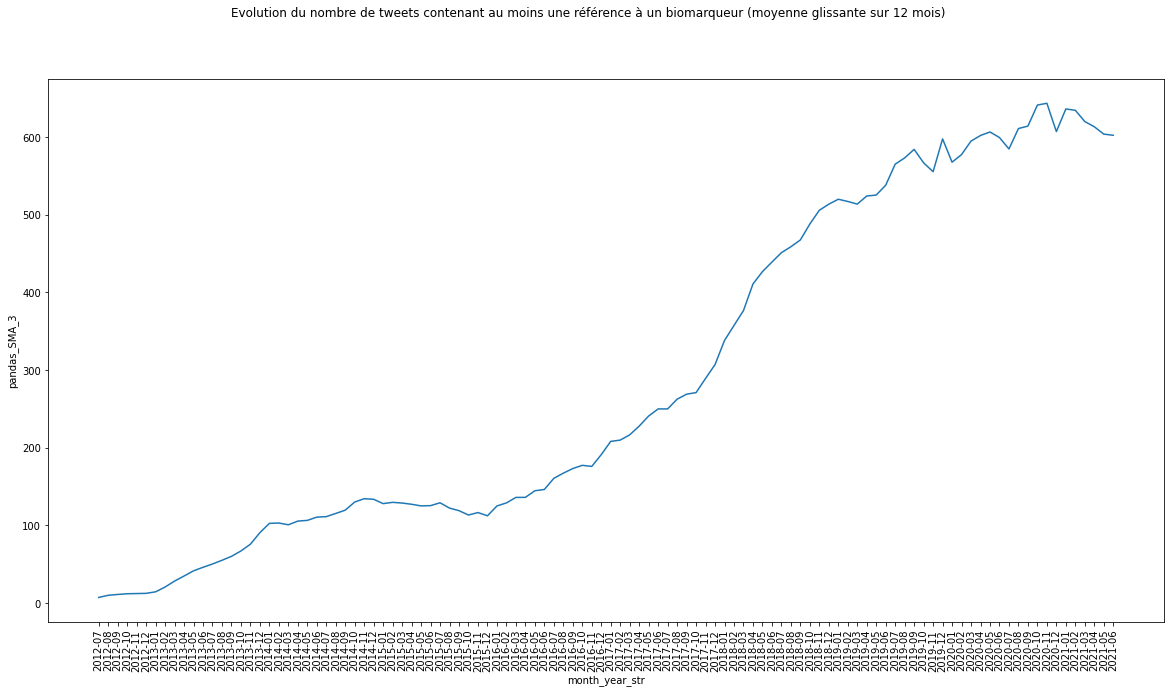

In [10]:
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
df2 = df.loc[(df["somme_biom"] >= 1) & (df["Year"] >= 2012)]
df2 = df2.groupby(["month_year"]).agg(nb_tweets = ("id", "count")).reset_index()
df2['pandas_SMA_3'] = df2.iloc[:,1].rolling(window=12, center = True).mean()
df2["month_year_str"] = df2["month_year"].dt.strftime("%Y-%m")
df2["log_nb_tweets"] = np.log(df2["nb_tweets"])


plt.figure(figsize=(20,10))

ax = sns.lineplot(data=df2, x="month_year_str", y="pandas_SMA_3")
ax.tick_params(axis='x', rotation=90)
#sns.lineplot(data=df2, x="month_year_str", y="nb_tweets")


#sns.lineplot(data=df2, x="month_year_str", y="log_nb_tweets")
plt.suptitle('Evolution du nombre de tweets contenant au moins une référence à un biomarqueur (moyenne glissante sur 12 mois)')
plt.show()

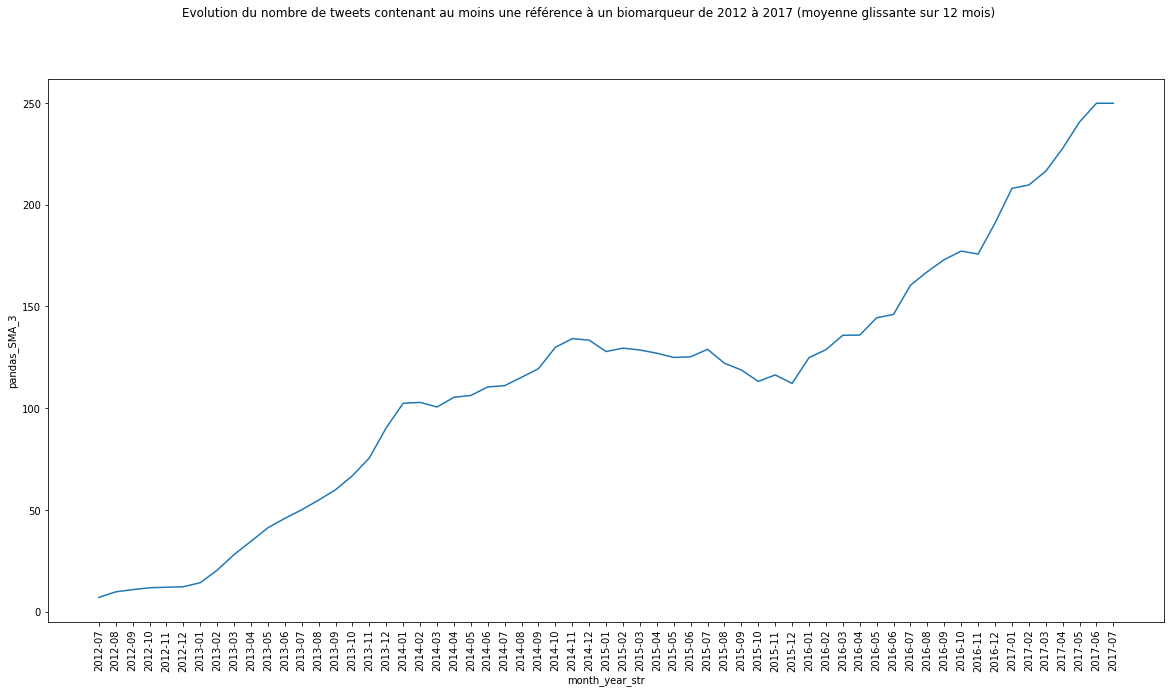

In [11]:
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
df2 = df.loc[(df["somme_biom"] >= 1) & (df["Year"] < 2018)]
df2 = df2.groupby(["month_year"]).agg(nb_tweets = ("id", "count")).reset_index()
df2['pandas_SMA_3'] = df2.iloc[:,1].rolling(window=12, center = True).mean()
df2["month_year_str"] = df2["month_year"].dt.strftime("%Y-%m")
df2["log_nb_tweets"] = np.log(df2["nb_tweets"])


plt.figure(figsize=(20,10))

ax = sns.lineplot(data=df2, x="month_year_str", y="pandas_SMA_3")
ax.tick_params(axis='x', rotation=90)
#sns.lineplot(data=df2, x="month_year_str", y="nb_tweets")


#sns.lineplot(data=df2, x="month_year_str", y="log_nb_tweets")
plt.suptitle('Evolution du nombre de tweets contenant au moins une référence à un biomarqueur de 2012 à 2017 (moyenne glissante sur 12 mois)')
plt.show()

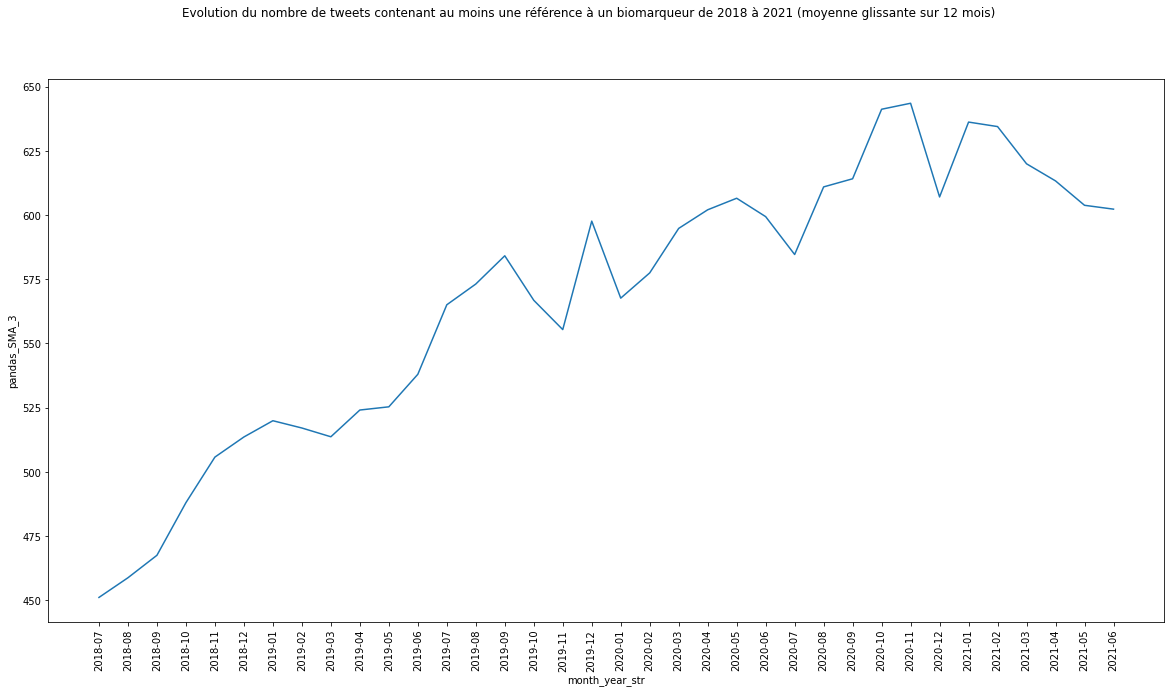

In [12]:
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
df2 = df.loc[(df["somme_biom"] >= 1) & (df["Year"] >= 2018)]
df2 = df2.groupby(["month_year"]).agg(nb_tweets = ("id", "count")).reset_index()
df2['pandas_SMA_3'] = df2.iloc[:,1].rolling(window=12, center = True).mean()
df2["month_year_str"] = df2["month_year"].dt.strftime("%Y-%m")
df2["log_nb_tweets"] = np.log(df2["nb_tweets"])


plt.figure(figsize=(20,10))

ax = sns.lineplot(data=df2, x="month_year_str", y="pandas_SMA_3")
ax.tick_params(axis='x', rotation=90)
#sns.lineplot(data=df2, x="month_year_str", y="nb_tweets")


#sns.lineplot(data=df2, x="month_year_str", y="log_nb_tweets")
plt.suptitle('Evolution du nombre de tweets contenant au moins une référence à un biomarqueur de 2018 à 2021 (moyenne glissante sur 12 mois)')
plt.show()

## Série corrigée des variation saisonnières

In [13]:
df2 = df.loc[(df["somme_biom"] >= 1) & (df["Year"] < 2018)]
df2 = df2.groupby(["month_year"]).agg(nb_tweets = ("id", "count")).reset_index()

df2.reset_index(inplace=True)
df2['month_year'] = df2["month_year"].dt.strftime("%Y-%m")
df2 = df2.set_index(pd.DatetimeIndex(df2['month_year']))
df2 = df2.drop(columns = ["index"])

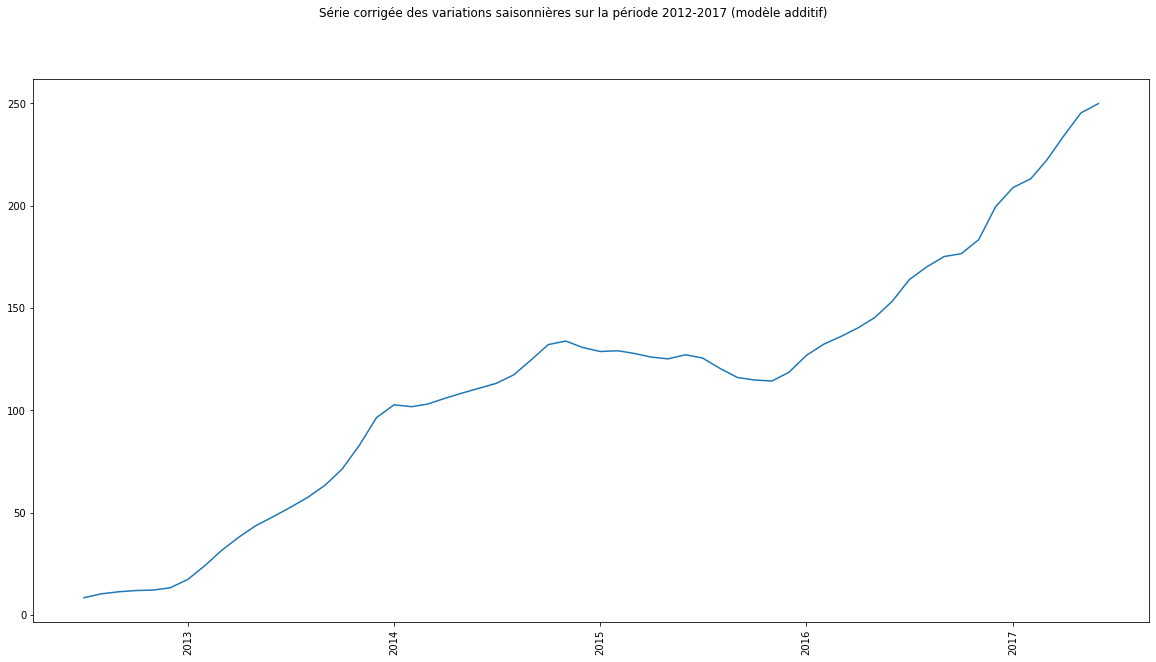

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt


decomp_x = seasonal_decompose(df2.nb_tweets,  model='additive', period=12)
plt.figure(figsize=(20,10))
trend = decomp_x.trend
plt.plot(trend)
plt.tick_params(axis='x', rotation=90)
plt.suptitle('Série corrigée des variations saisonnières sur la période 2012-2017 (modèle additif)')
plt.show()



In [15]:
df2 = df.loc[(df["somme_biom"] >= 1) & (df["Year"] >= 2018)]
df2 = df2.groupby(["month_year"]).agg(nb_tweets = ("id", "count")).reset_index()

df2.reset_index(inplace=True)
df2['month_year'] = df2["month_year"].dt.strftime("%Y-%m")
df2 = df2.set_index(pd.DatetimeIndex(df2['month_year']))
df2 = df2.drop(columns = ["index"])

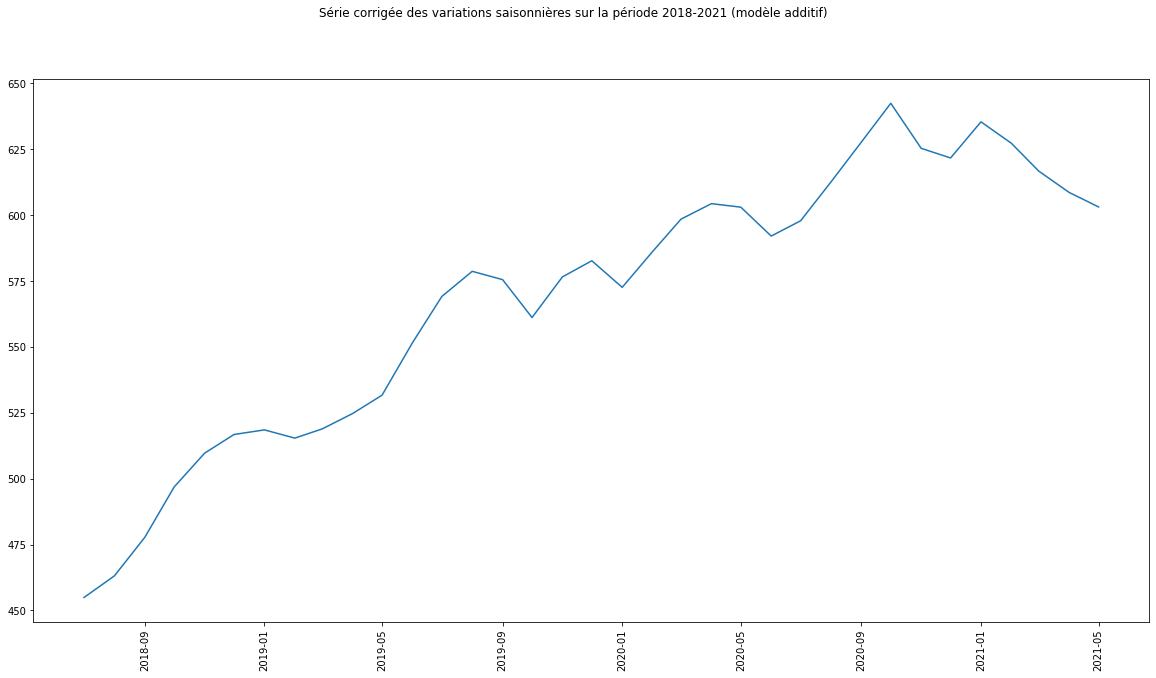

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt


decomp_x = seasonal_decompose(df2.nb_tweets,  model='additive', period=12)
plt.figure(figsize=(20,10))
trend = decomp_x.trend
plt.plot(trend)
plt.tick_params(axis='x', rotation=90)
plt.suptitle('Série corrigée des variations saisonnières sur la période 2018-2021 (modèle additif)')
plt.show()



### 2012-2017

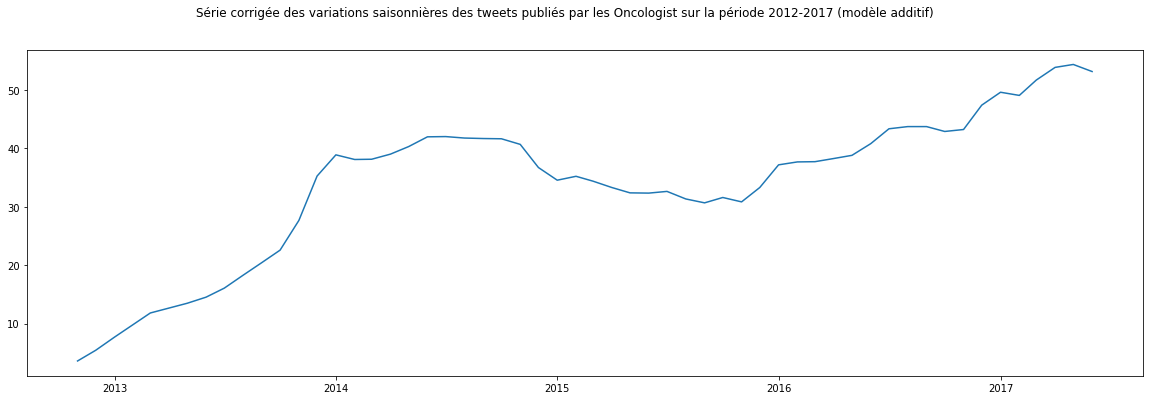

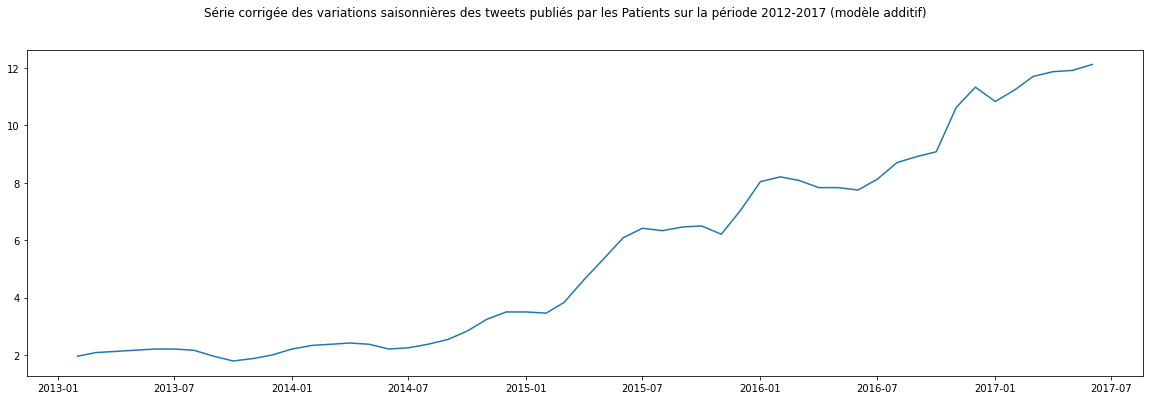

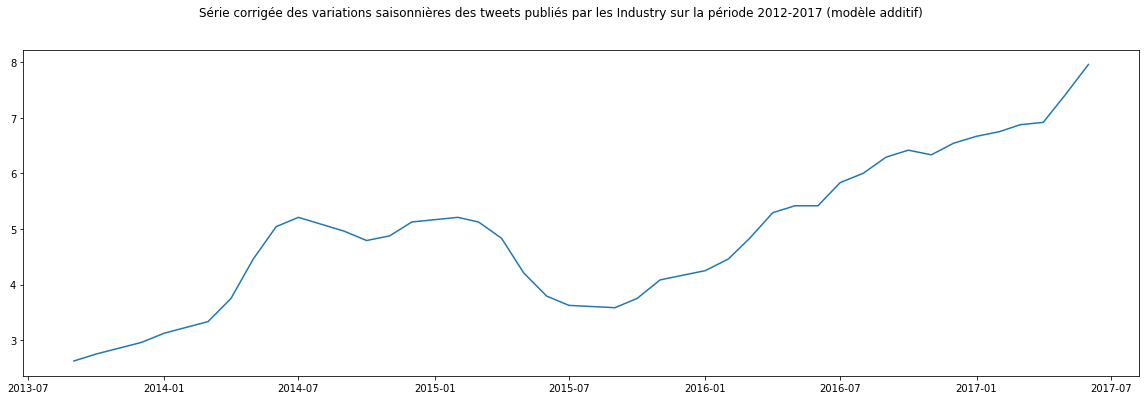

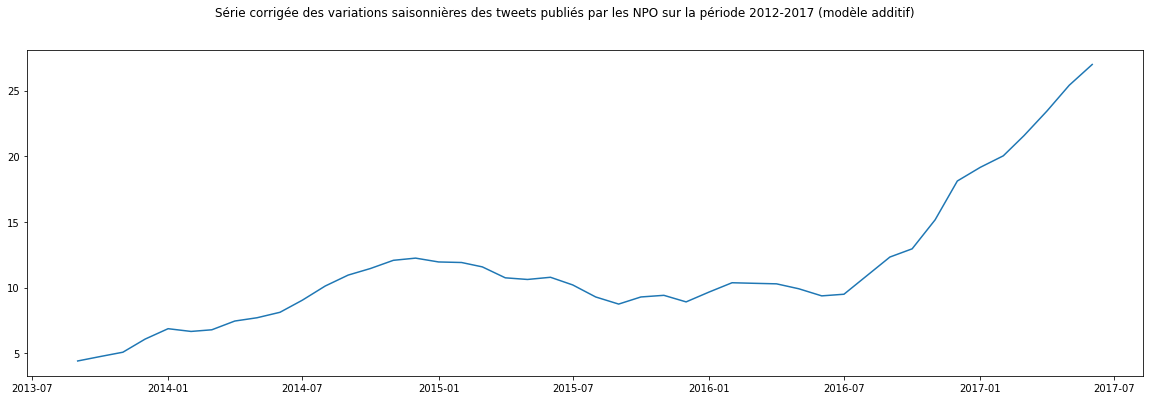

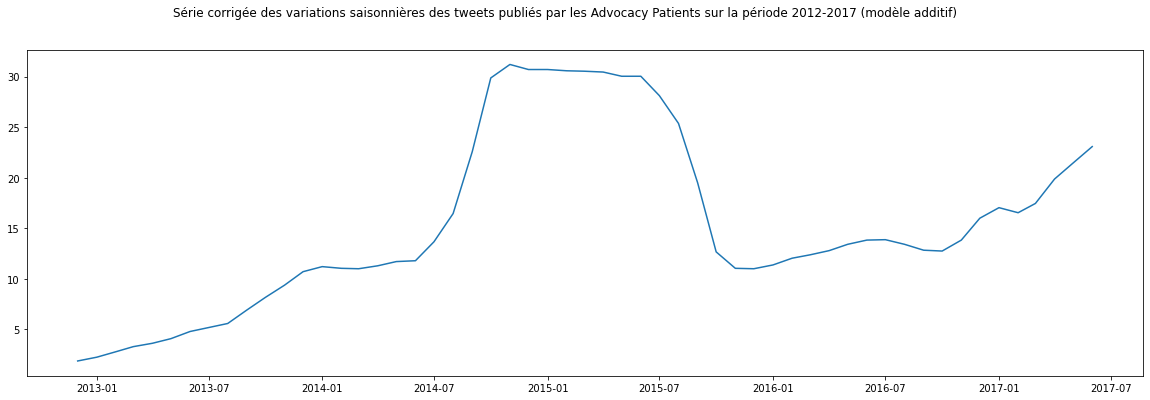

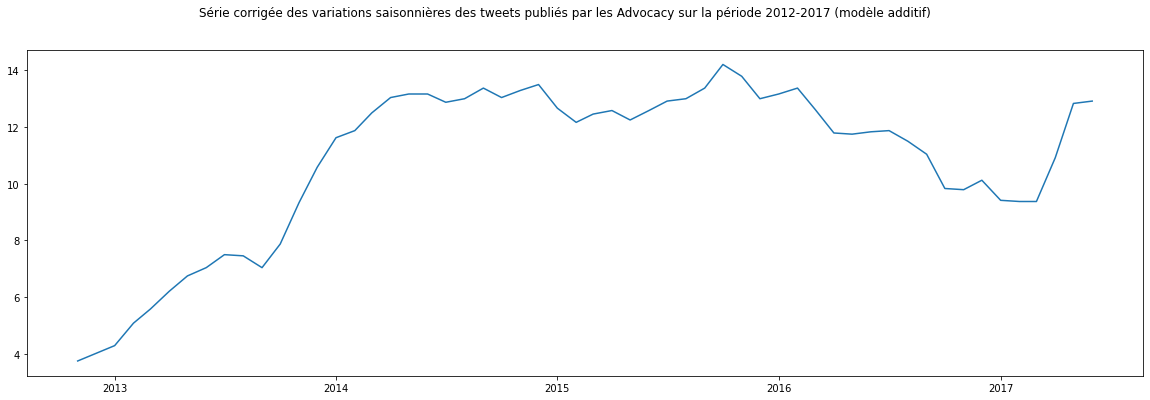

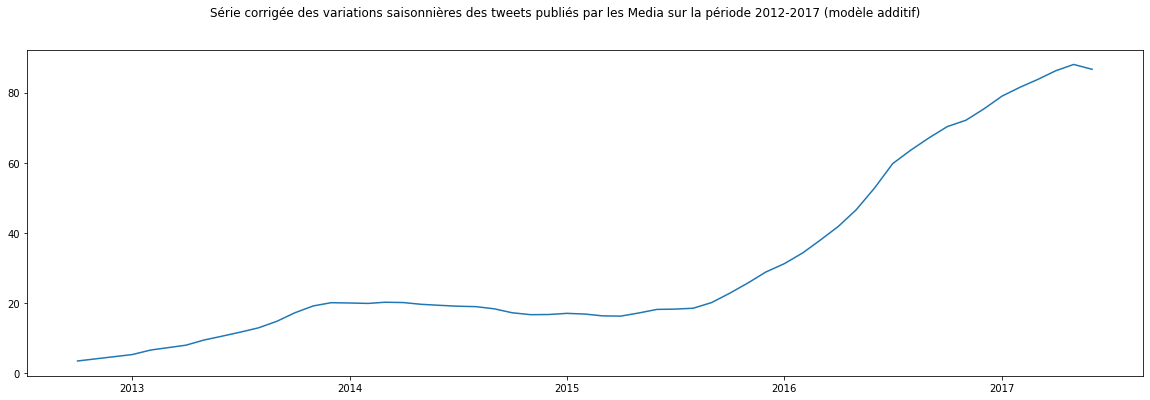

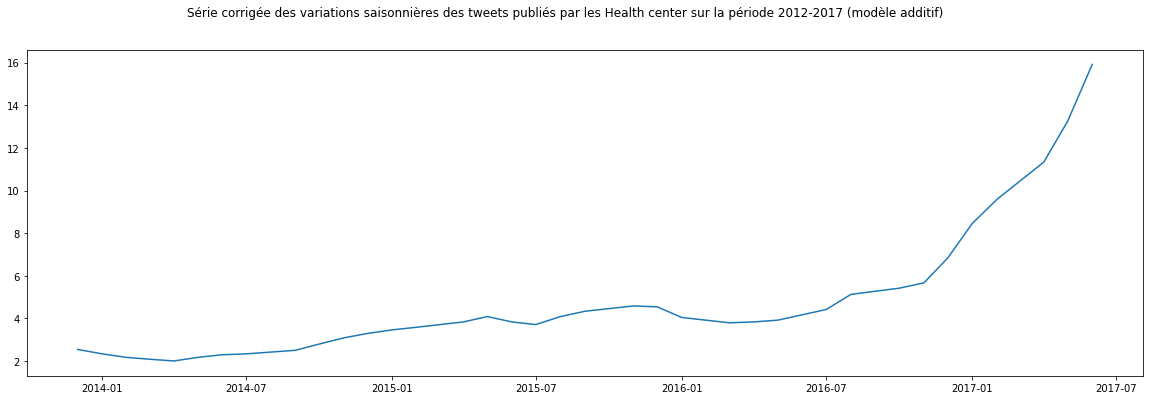

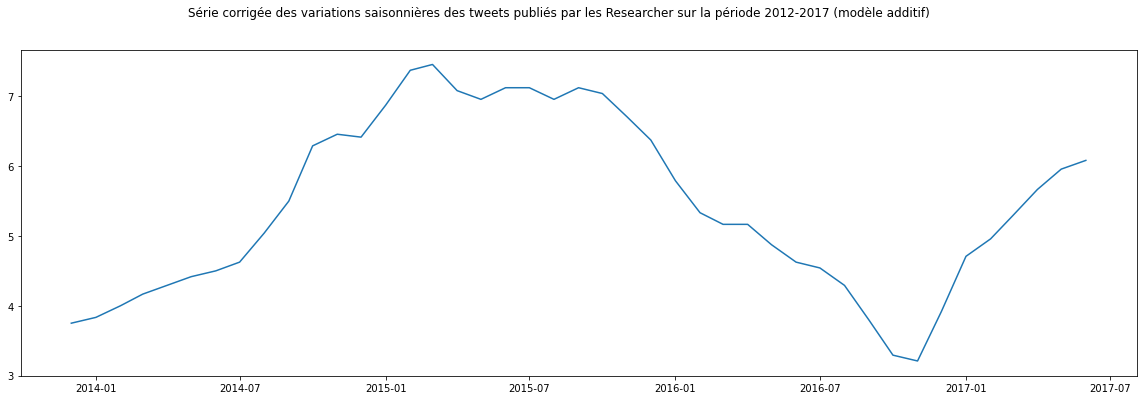

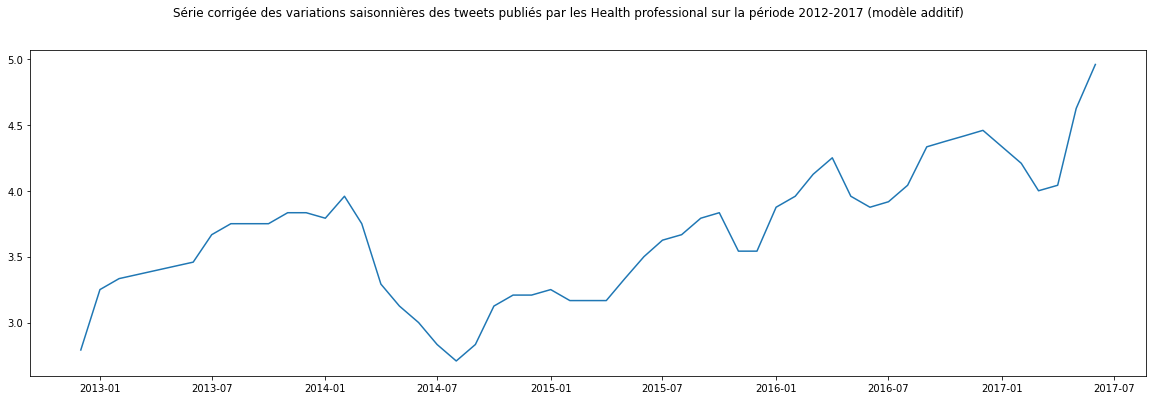

In [19]:

for i, x in enumerate(df["User_status"].unique()):

    df2 = df.loc[(df["somme_biom"] >= 1) & (df["Year"] < 2018) & (df["User_status"] == x)]
    df2 = df2.groupby(["month_year"]).agg(nb_tweets = ("id", "count")).reset_index()

    df2.reset_index(inplace=True)
    df2['month_year'] = df2["month_year"].dt.strftime("%Y-%m")
    df2 = df2.set_index(pd.DatetimeIndex(df2['month_year']))
    df2 = df2.drop(columns = ["index"])
    
    decomp_x = seasonal_decompose(df2.nb_tweets,  model='multiplicative', period=12)
    
    trend = decomp_x.trend
    plt.figure(figsize=(20,6))
    plt.plot(trend)
    #plt.tick_params(axis='x', rotation=90)
    plt.suptitle(f'Série corrigée des variations saisonnières des tweets publiés par les {x} sur la période 2012-2017 (modèle additif) ')
    plt.show()
    

    

### 2018-2021

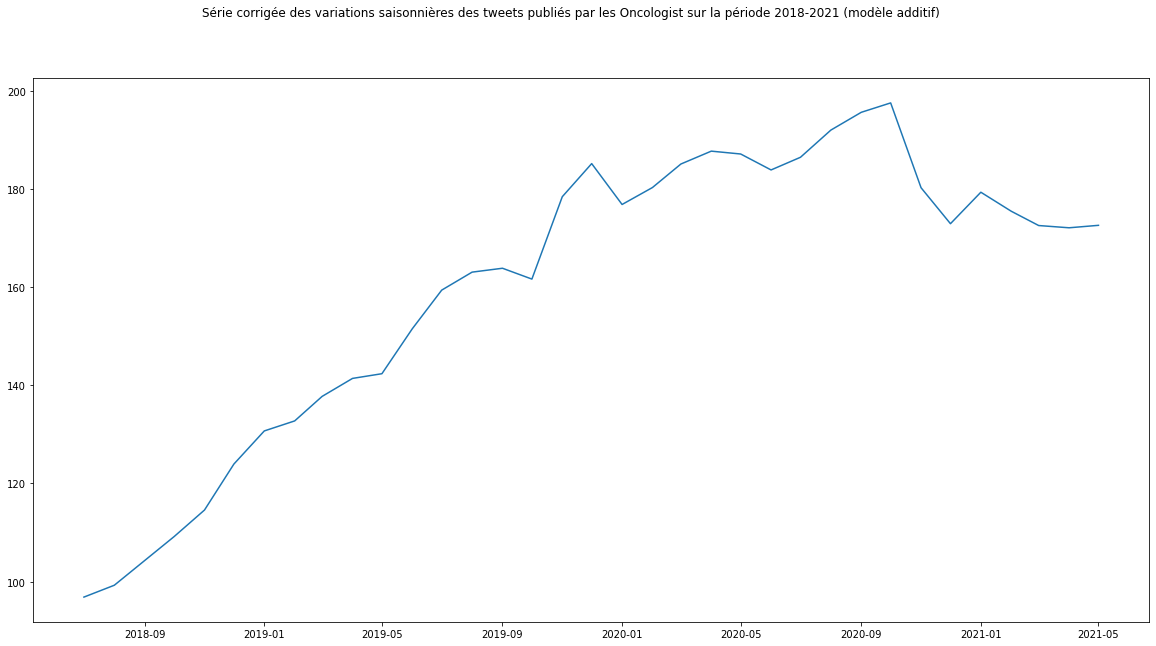

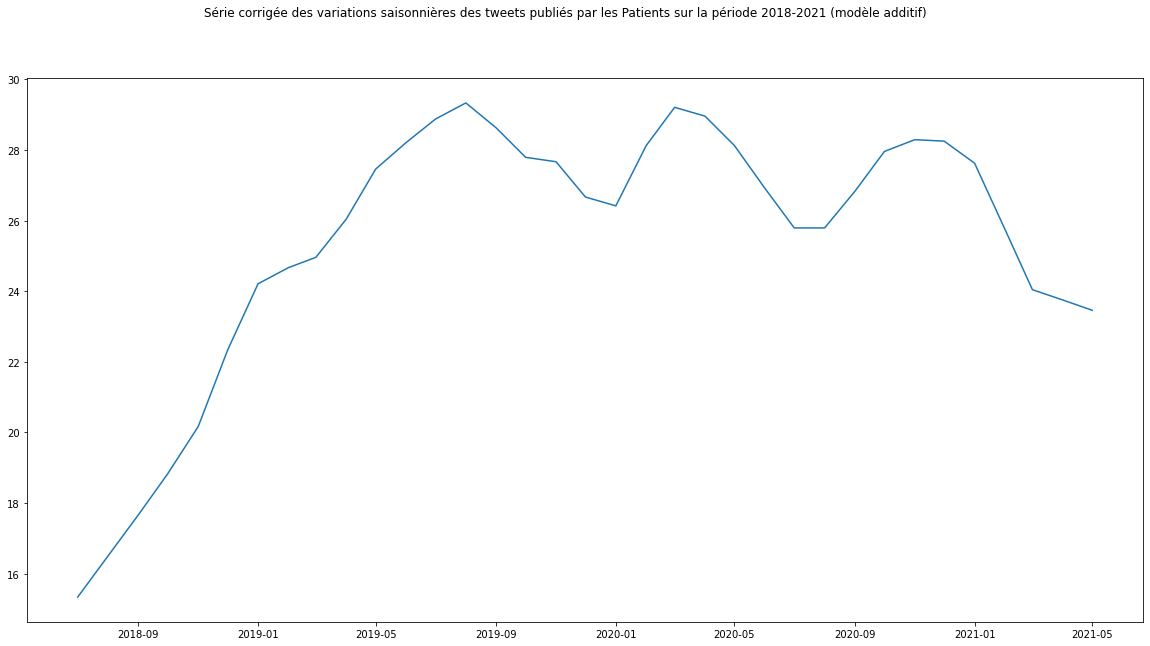

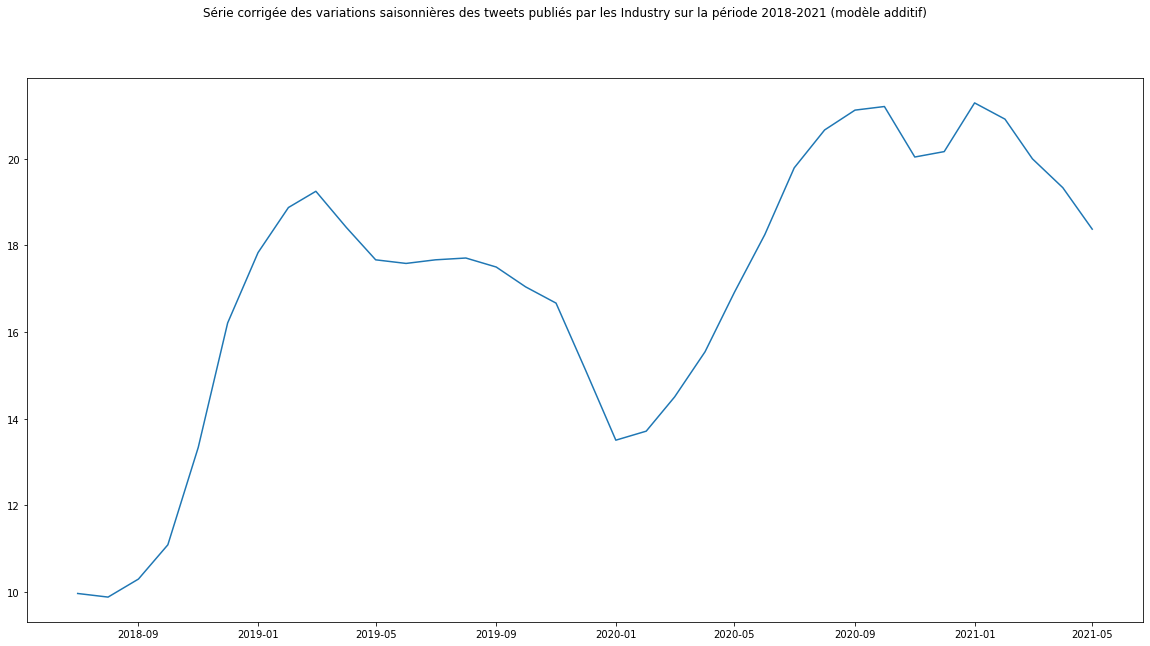

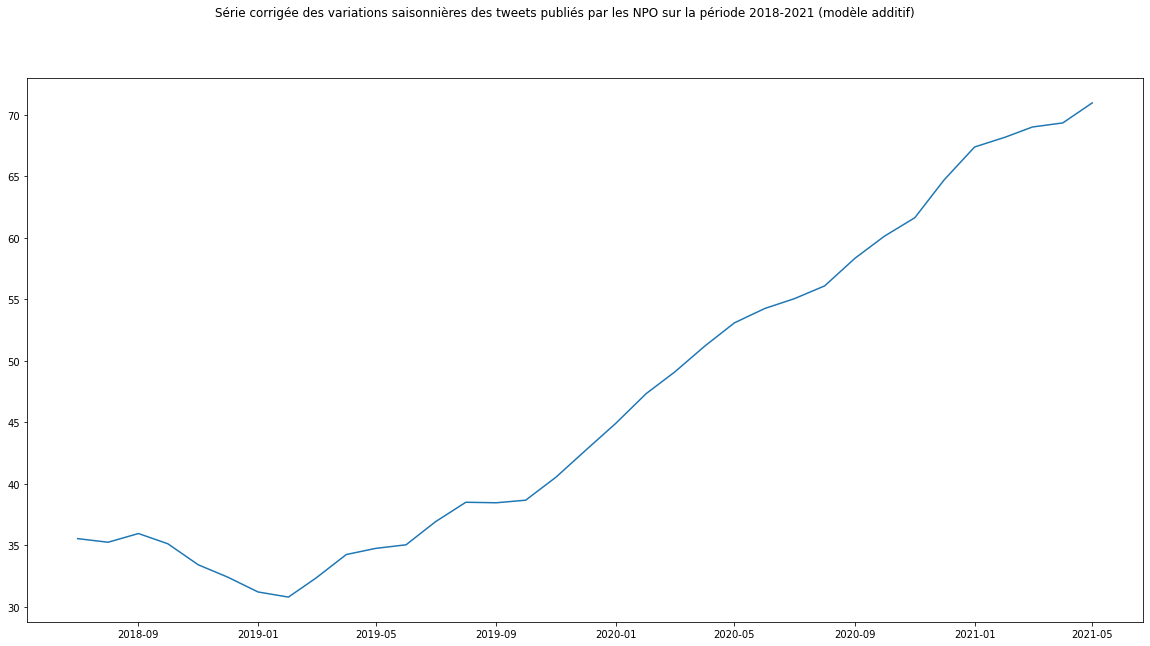

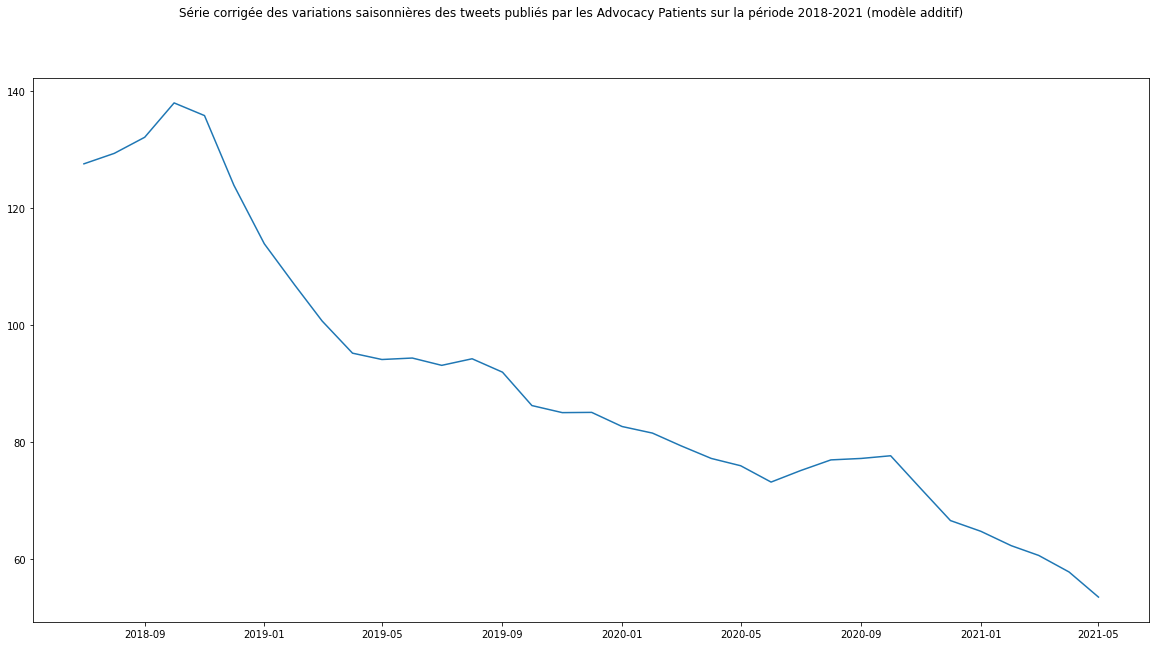

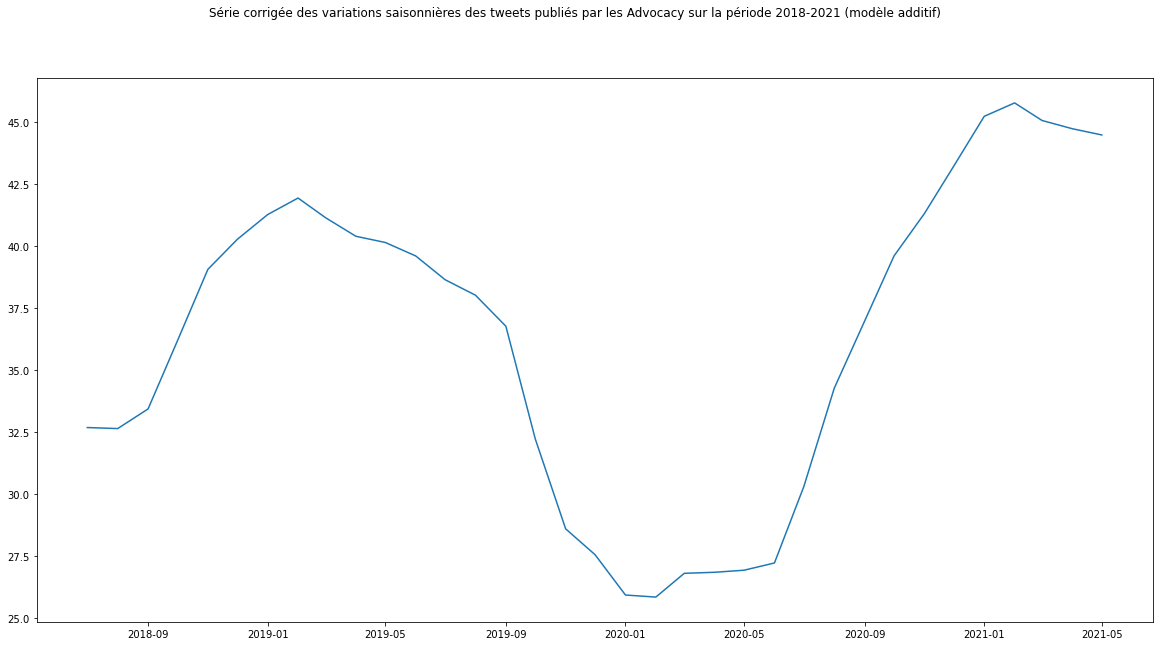

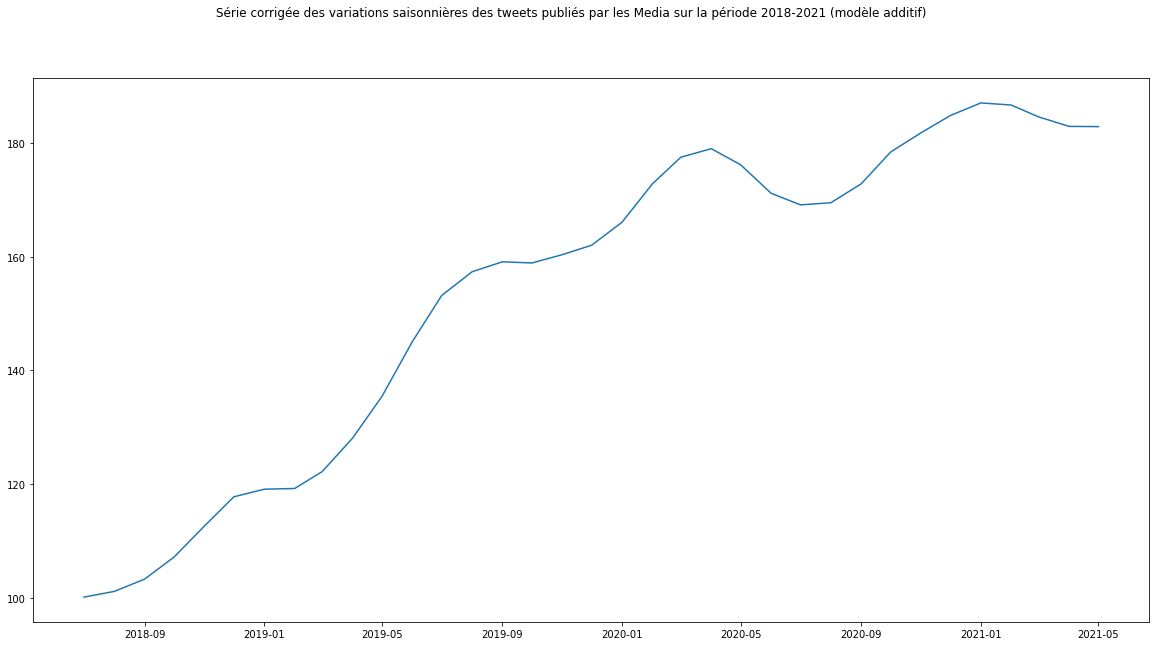

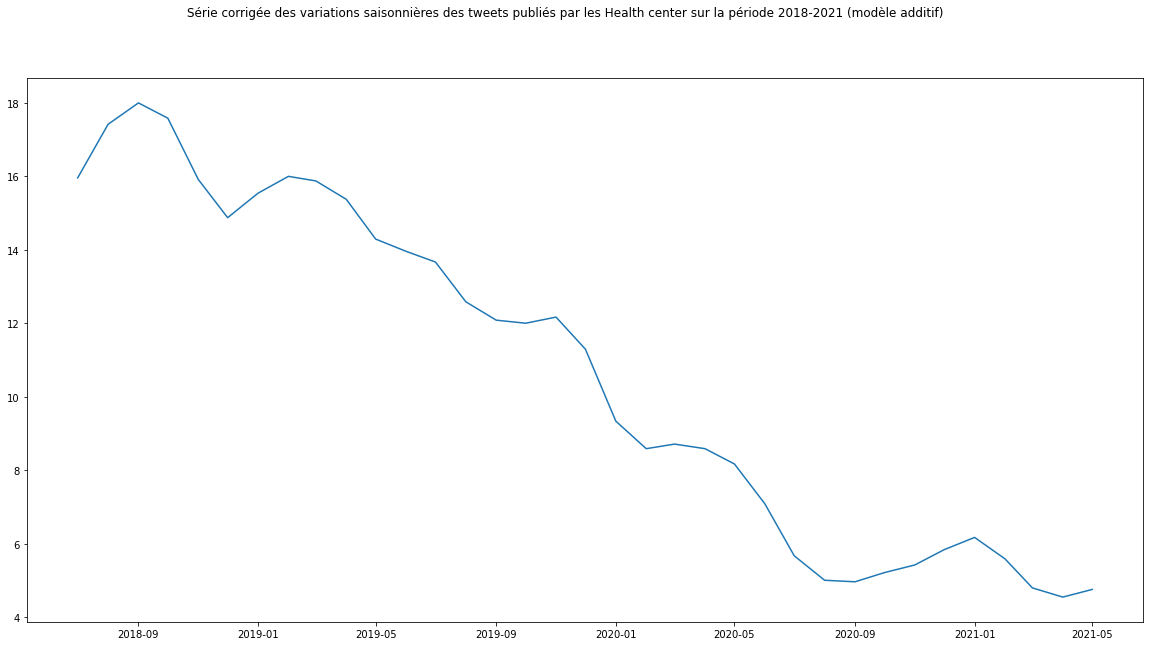

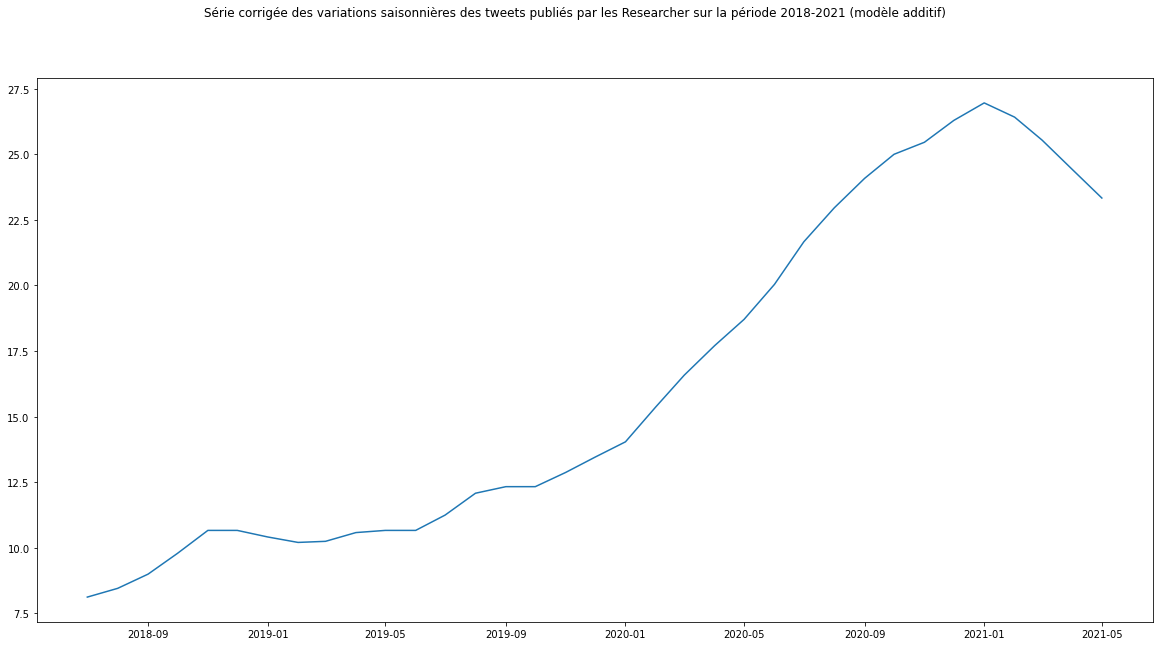

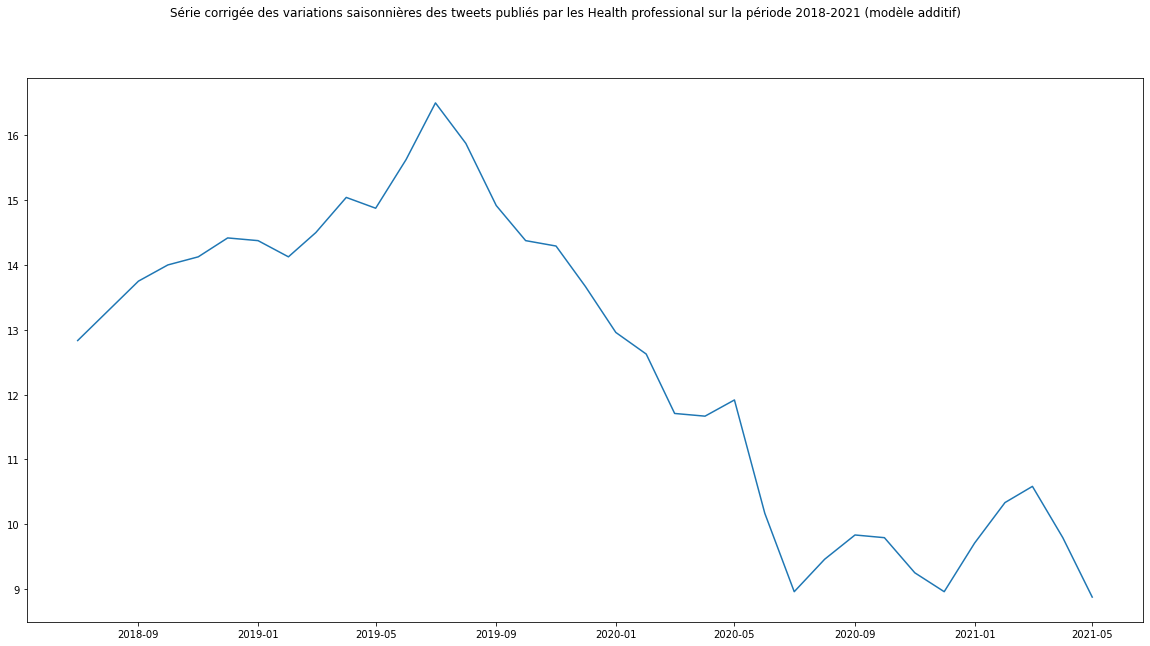

In [20]:

for i, x in enumerate(df["User_status"].unique()):

    df2 = df.loc[(df["somme_biom"] >= 1) & (df["Year"] >= 2018) & (df["User_status"] == x)]
    df2 = df2.groupby(["month_year"]).agg(nb_tweets = ("id", "count")).reset_index()

    df2.reset_index(inplace=True)
    df2['month_year'] = df2["month_year"].dt.strftime("%Y-%m")
    df2 = df2.set_index(pd.DatetimeIndex(df2['month_year']))
    df2 = df2.drop(columns = ["index"])
    
    decomp_x = seasonal_decompose(df2.nb_tweets,  model='additive', period=12)
    
    trend = decomp_x.trend
    plt.figure(figsize=(20,10))
    plt.plot(trend)
    #plt.tick_params(axis='x', rotation=90)
    plt.suptitle(f'Série corrigée des variations saisonnières des tweets publiés par les {x} sur la période 2018-2021 (modèle additif) ')
    plt.show()
    

    